# Picking a good prior

The goals of this lesson and the next one are to go through the modeling workflow of identifying prior information, constructing and fitting an initial model, and iterating based on what we learn from the first model.

In this lesson, we focus on encoding prior information into a prior distribution and fitting an initial model.

## Prep plan

* The medical trial model section below should take ~1 hour.
* The McElreath reading should take ~45 minutes.
* This section on the Normal and Normal-Inverse-Gamma distributions after the reading should take ~45 minutes.

## Medical trial model

You know this model well by now, but we are introducing a small change — the parameters of the Beta prior are not specified. (They used to be $\alpha=1$ and $\beta=1$.)

$$\begin{align}
p &\sim \text{Beta}(\alpha,\beta)\\
x &\sim\text{Binomial}(n,p)
\end{align}$$

### Review: Session 3

We start by reviewing the prior and prior-predictive distributions of this model with $\alpha=1$ and $\beta=1$, which is something we covered in the Session 3 pre-class work.

In [2]:
import pymc as pm

def create_model(alpha, beta, n=100, improved=50):
    '''
    Create a Beta-Binomial model with the given `alpha` and `beta` parameters
    for the Beta prior over p.

    We also specify the number of trials `n` and the number of improved outcomes
    `improved`, but we won't actually use these today since we're looking at the
    prior and prior-predictive distributions only, and not the posterior.
    '''
    with pm.Model() as model:
        # Prior
        p = pm.Beta('p', alpha=alpha, beta=beta)
        # Likelihood
        pm.Binomial('x', n=n, p=p, observed=improved)
    return model

model = create_model(alpha=1, beta=1)

# Sample from the prior
n_samples = 10_000
with model:
    inference = pm.sample_prior_predictive(n_samples)

inference

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

After running the code above, the `inference` object contains samples from the prior ($p$) and prior-predictive ($x$) distributions. Click on the ▶ above to see the prior and prior-predictive data.

Next, we plot the marginal distribution over $p$ and $x$, respectively. This code was slightly modified from Session 3.

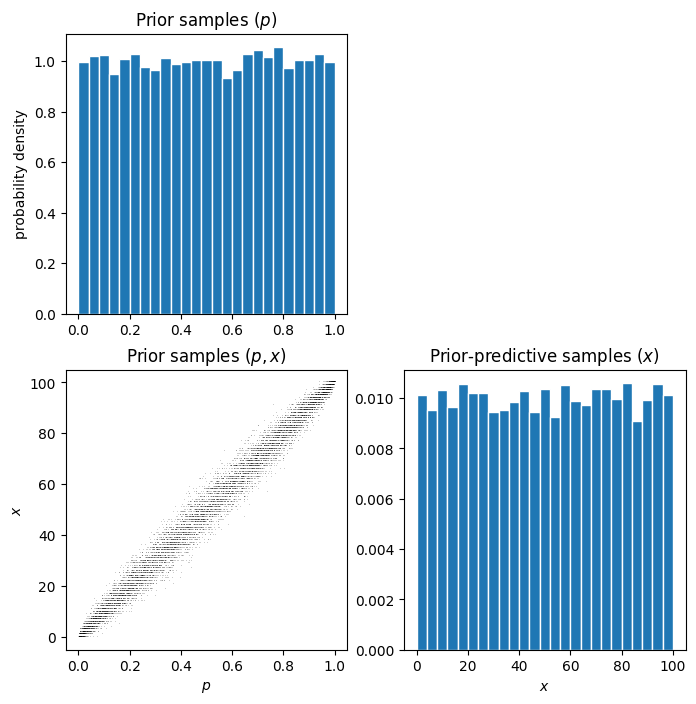

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def make_prior_plots(inference):
    '''
    Plot the prior and prior-predictive distributions over p and x, respectively
    using the given `inference` object, produced by sample_prior_predictive().
    '''
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 2, 1)
    plt.title('Prior samples ($p$)')
    plt.ylabel('probability density')
    plt.hist(
        inference.prior.p.values.flatten(), bins=np.arange(0, 1.01, 0.04), density=True,
        edgecolor='white')

    plt.subplot(2, 2, 4)
    plt.title('Prior-predictive samples ($x$)')
    plt.xlabel('$x$')
    plt.ylabel('probability density')
    plt.hist(
        inference.prior_predictive.x.values.flatten(), bins=np.arange(0, 101, 4) - 0.01, density=True,
        edgecolor='white')

    plt.subplot(2, 2, 3)
    plt.title('Prior samples $(p,x)$')
    plt.xlabel('$p$')
    plt.ylabel('$x$')
    plt.plot(
        inference.prior.p.values.flatten(),
        inference.prior_predictive.x.values.flatten(),
        'k,', alpha=0.2)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-5, 105)

    plt.show()

make_prior_plots(inference)

Note the feint horizontal lines in the scatter plot above. They appear because $x$ is discrete (an integer). We don't observe vertical lines since $p$ is continuous.

### New: Modify the prior

Next, we'll go through a few made-up scenarios where we received specific information about $p$ and want to encode that in the Beta prior distribution. Complete each of these exercises to practice the different techniques for fitting a prior distribution to the given information. We will use these techniques again in class.

#### Scenario 1: Solving equations

We are told that, in the prior, the expected value (mean) of $p$ should be 0.6 and the standard deviation should be 0.1. Our task is to determine the values of $\alpha$ and $\beta$ such that $\text{Beta}(\alpha,\beta)$ has the correct mean and standard deviation.

You can look up the formulas for the mean and variance of the Beta distribution in Wikipedia. Use those formulas and the values given above to solve for $\alpha$ and $\beta$ by hand or using a computational tool like SymPy, Sage, etc.

Reuse the code above to plot the prior and prior-predictive distributions of your solution. Verify that the mean and standard deviation are indeed 0.6 and 0.1.

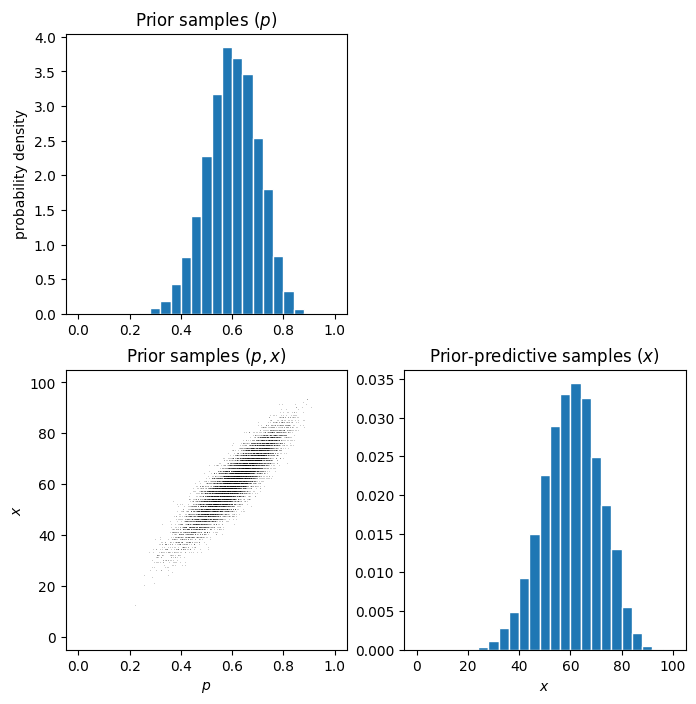

Mean: 0.6
Standard Deviation: 0.1


In [4]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM

# TASK: Compute the solution
alpha = 13.8
beta = 9.2

# TASK: Make the plot
model = create_model(alpha, beta)
with model:
    inference = pm.sample_prior_predictive(n_samples)
make_prior_plots(inference)

# TASK: Verify that the mean and standard deviation of the samples are correct
mean = np.mean(inference.prior.p.values.flatten())
std = np.std(inference.prior.p.values.flatten())
print(f"Mean: {round(mean, 2)}")
print(f"Standard Deviation: {round(std, 2)}")

[(13.8000000000000, 9.20000000000000)]
13.8 9.2


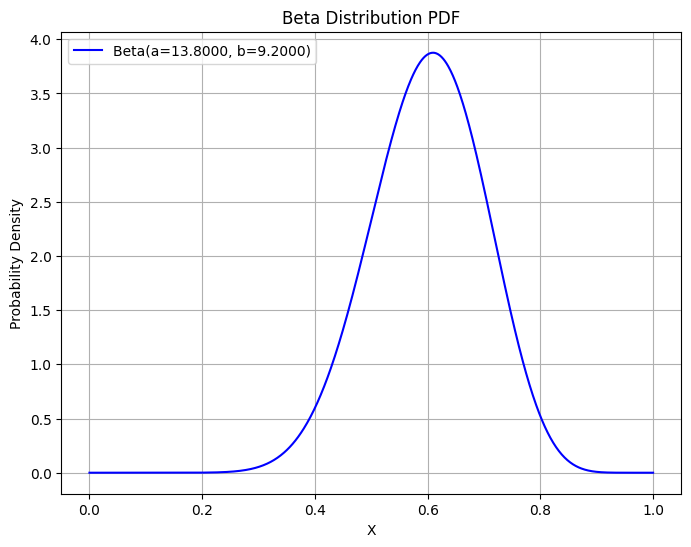

In [5]:
from sympy import solve
from sympy.abc import a, b
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

# Solve the system of equations for numerical values of a and b
solution = solve([a/(a+b) - 0.6, (a*b / ((a+b)**2*(a+b+1)))**0.5 - 0.1], [a, b])
print(solution)
# Extract numerical values for alpha and beta
# Assuming a and b are positive for a valid Beta distribution
alpha = float(solution[0][0])
beta = float(solution[0][1])
print(alpha, beta)
# Plot the Beta distribution PDF using the numerical values
x = np.linspace(0, 1, 1000)
pdf_values = sts.beta.pdf(x, alpha, beta)
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label=f'Beta(a={alpha:.4f}, b={beta:.4f})', color='blue')
plt.title('Beta Distribution PDF')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

#### Scenario 2: Numerical optimization

We are told that, in the prior, $p\in[0.07, 0.32]$ with 80% certainty.

We can write this in terms of the CDF of the Beta:

* $F_{\text{Beta}}(0.07\,|\,\alpha,\beta) = 0.1$
* $F_{\text{Beta}}(0.32\,|\,\alpha,\beta) = 0.9$

Make sure you're happy with the equations above! We want the difference between the CDF evaluated at the left of the interval (0.07) and the right of the interval (0.32) to equal $80\% = 0.8 = 0.9 - 0.1$.

We want to solve for $\alpha$ and $\beta$ as before. If we had a neat formula for the CDF, we could use the same approach as in Scenario 1, but we don't. The CDF is a non-analytical function and is actually [defined in terms of an integral](https://en.wikipedia.org/wiki/Beta_function#Incomplete_beta_function).

Instead of solving equations, we use numerical optimization.

If you are unfamiliar with optimizing functions in SciPy, work through this reading: [Scheffler, C. (2018). _Optimization in SciPy_](https://course-resources.minerva.edu/uploaded_files/mke/00075975-0061/optimization-in-scipy.pdf). These notes explain how to use the `minimize()` function in SciPy for finding a minimum (or maximum) of a function. Focus on actually running the code provided in the examples. Compare the output from your code to what you would expect the solution to each problem to be, based on the information in each example. Experiment with different functions or different initial values. **You need to know how to maximize or minimize a function of 1 or more variables to be ready for class.**

Your task is to create a function that is minimized when the CDF constraints above are both satisfied. You can do this by creating an objective function of the sum of squared residuals of the constraints.

$$
\left(F_{\text{Beta}}(0.07\,|\,\alpha,\beta) - 0.1\right)^2 +
\left(F_{\text{Beta}}(0.32\,|\,\alpha,\beta) - 0.9\right)^2
$$

Use SciPy to find the values of $\alpha$ and $\beta$ that minimize this objective function, plot the resulting prior and prior-predictive distributions, and verify that 80% of the sample values of $p$ are in the interval $[0.07, 0.32]$.

[ 2.70796616 11.93464938]


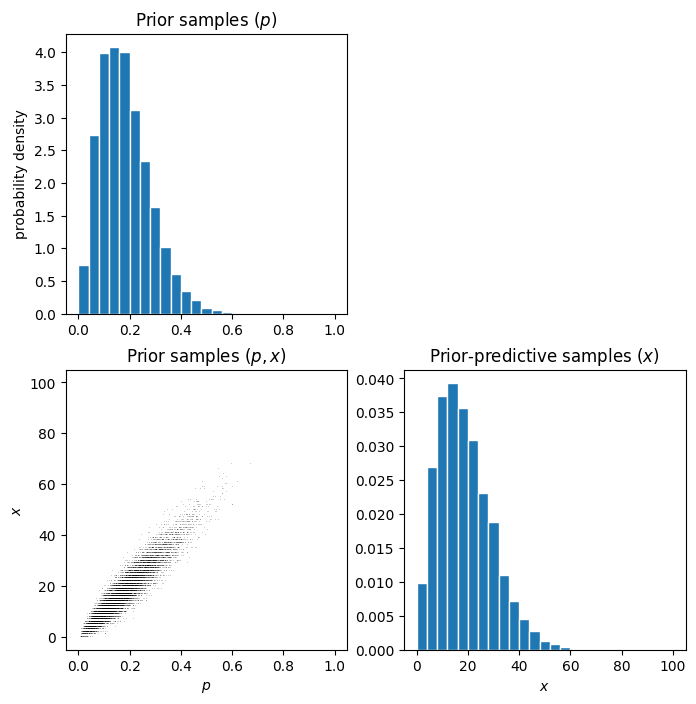

79.73%


In [6]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM
from scipy.optimize import minimize

# TASK: Compute the solution
def F(x, a, b):
  return sts.beta.cdf(x, a,b)

def f(parameters):
  a, b = parameters
  return (F(0.07, a, b) - 0.1)**2 + (F(0.32, a, b) - 0.9)**2

initial_array = [1,1]
result = minimize(f, initial_array)
print(result.x)

a = result.x[0]
b = result.x[1]

# TASK: Make the plot
model = create_model(a, b)
with model:
    inference = pm.sample_prior_predictive(n_samples)
make_prior_plots(inference)

# TASK: Verify that 80% of the samples in the interval [0.07, 0.32]
samples = inference.prior.p.values.flatten()
count = np.sum((samples >= 0.07) & (samples <= 0.32)) / len(samples)
print(f"{round(count * 100, 2)}%")

## Required reading: Statistical rethinking

Next, we move on to understanding the Normal distribution and its uses. In class, we will combine the work you did on fitting priors above with the readings below, to fit the prior of a Normal likelihood.

Read Sections 4.1–4.3 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher's page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O'Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/12_Chapter04.xhtml). Log in with your library card number.

Outline

* **The introduction (_Geocentric models_) is required** (520 words). It revisits the common dictum that all models are wrong but some models are useful. An important addendum here is that different models (even wrong ones) are useful in different contexts.
* **Section 4.1 (_Why normal distributions are normal_) is required** (2390 words). This section motivates why the Normal distribution comes up a lot in statistical modeling. It also discusses some of the properties of the Normal distribution (light tails is an important one) and how they may or may not fit our modeling assumptions. We use the Normal distribution in today’s case study.
* **Section 4.2 (_A language for describing models_) is required** (840 words). The notation presented here is exactly what we in this course for writing down a statistical model. This notation gets used _all the time_ in academic and other publications and it is important to be able to read and write it.
* Section 4.3 (_Gaussian model of height_) is optional (6140 words). This section works through a simple case study using a Normal likelihood function — much like we will do in class. It is a good read with lots of useful tips if you want to deepen your understanding of simple statistical models before we get to more complicated models a little later in this course.

### The Normal and Normal-Inverse-Gamma distributions

In this session, we model data using the Normal distribution with unknown mean and variance as our likelihood function. This means the data values are real numbers, the likelihood function is a Normal distribution, $\text{data}\sim\text{Normal}(\text{mean}, \text{variance})$ where the _mean_ and _variance_ are the parameters we want to estimate. This means we are modeling two unknown parameters simultaneously so, we have a more complicated, 2-dimensional, prior than before. Previously, we worked with estimating one parameter and the prior was 1-dimensional.

The Normal-Inverse-Gamma distribution is a conjugate prior for the Normal likelihood with unknown mean and variance. You can remind yourself what _conjugate prior_ means by watching [this video](https://www.youtube.com/watch?v=aPNrhR0dFi8) (6 minutes). This means we can compute the posterior distribution analytically if we want to. We won’t do that today since our aim is to learn to use PyMC which works for conjugate and non-conjugate priors. In practice, you might want to use a conjugate prior if you can since it provides you with exact posteriors — without any sampling or numerical errors.

Different sources use different (but equivalent) ways of parameterizing the Normal likelihood function. The possibilities are

* mean $\mu$ and variance $\sigma^2$ with a Normal-Inverse-Gamma prior (we use this one)
* mean $\mu$ and standard deviation $\sigma$ with a Normal-Gamma prior
* mean $\mu$ and precision $\tau = 1/\sigma^2$ with a Normal-Gamma prior

These parameterizations can all be mapped onto each other since

$$\text{variance} = (\text{standard deviation})² = \frac{1}{\text{precision}}$$

Depending on which parameterization is used, a different conjugate prior is appropriate. This is because the algebraic form of the likelihood depends on the parameterization, and the algebraic form of the conjugate prior has to match that of the likelihood. This is not all that important to understand for class today. Just take note that different likelihood functions have different appropriate conjugate priors. You can see the different conjugate priors if you look up the Normal distribution in [Wikipedia's table of conjugate distributions](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

We proceed with the mean and variance parameterization of the Normal likelihood function.

Likelihood:

$$x_i\sim\text{Normal}(m, s^2) \quad\text{i.i.d. for all } i$$

Prior:

$$m, s^2\sim\text{Normal-Inverse-Gamma}(\mu_0, \nu_0, \alpha_0, \beta_0)$$

**Note:** We use $m$ and $s^2$ to refer to the mean and variance of the data distribution instead of $\mu$ and $\sigma^2$. This is to avoid confusion since the Normal-Inverse-Gamma distribution also has a $\mu$ parameter and we need to give them different names. So, $m$ is the unknown mean of the data set and $\mu_0$ is a parameter of the Normal-Inverse-Gamma distribution.

**Optional reading:** Fletcher, T. (2018). [Gaussian priors](https://course-resources.minerva.edu/uploaded_files/mke/00207145-7142/fletcher2018gaussian.html). A derivation of why the Inverse-Gamma distribution has the appropriate algebraic form to be a conjugate prior for the variance parameter in a Normal likelihood function. This should deepen your understanding of the relationship between a likelihood function and its conjugate prior — that they have the same algebraic form with respect to the unknown parameter(s). (1100 words)

**Optional reading:** Murphy, K.P. (2007). [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf). If you want the full mathematical treatment of deriving conjugate priors for Gaussian likelihoods with unknown mean and variance, work through this paper.

### Prior-predictive distribution: Samples from the Normal-Inverse-Gamma prior correspond to Normal distributions over the data

The support of the Normal-Inverse-Gamma distribution is $(m,s^2)$ such that $m\in\mathbb{R}$ and $s^2\in\mathbb{R}^+$. So if we generate an $(m,s^2)$ sample from the Normal-Inverse-Gamma distribution, we can interpret $m$ and $s^2$ as the mean and variance of a Normal distribution. This shouldn’t be a surprise. The Normal-Inverse-Gamma distribution is useful precisely because it is a conjugate distribution over the mean and variance parameters of a Normal likelihood, and we use the Normal likelihood function since we assume our data set is normally distributed. As a result, we can visualize a sample from the Normal-Inverse-Gamma distribution by plotting the Normal PDF corresponding to the sampled mean and variance values, $(m,s^2).$

**Example:** If we get the four samples $(1, 2)$, $(2, 0.1)$, $(-1, 1)$, $(3, 3)$ from a Normal-Inverse-Gamma distribution, each one represents the mean and variance of one Normal PDF. **Run the code cell below to plot these four PDFs.**

We will see more of these plots in class today. This can be a useful way of seeing how the typical parameter values change from the prior distribution to the posterior distribution.

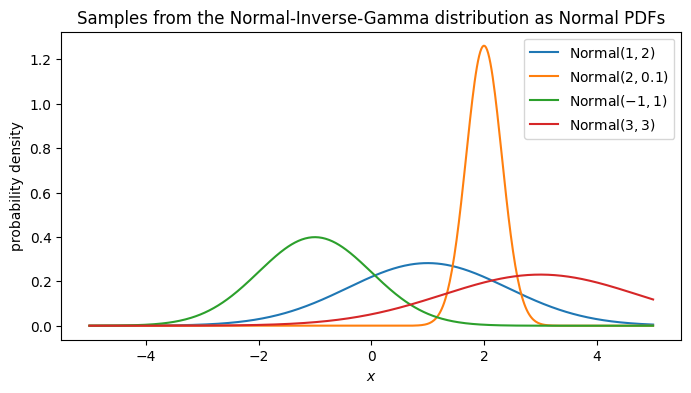

In [7]:
import matplotlib.pyplot as plt

samples = [(1, 2), (2, 0.1), (-1, 1), (3, 3)]

plt.figure(figsize=(8, 4))
plt.title('Samples from the Normal-Inverse-Gamma distribution as Normal PDFs')
plt.xlabel('$x$')
plt.ylabel('probability density')
x = np.linspace(-5, 5, 500)
for sample in samples:
    mean = sample[0]
    variance = sample[1]
    y = sts.norm.pdf(x, loc=mean, scale=np.sqrt(variance))
    plt.plot(x, y, label=f'Normal$({mean}, {variance})$')
plt.legend()
plt.show()